# DLthon - 길찾은 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
import pathlib
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import basemodels, topmodels, utils

2025-01-19 17:57:39.972824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 17:57:39.983487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737277059.997556  137053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737277060.001754  137053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:57:40.018782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
base_dir = pathlib.Path('data_jellyfish/Train_Test_Valid')

train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "train",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

val_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "valid",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / "test",
    image_size = (224, 224),
    batch_size = 64,
    label_mode='categorical')

Found 900 files belonging to 6 classes.


I0000 00:00:1737277062.437412  137053 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.




## Basemodel

여기에 ResNet50 결과 입력

## EfficientNetV2L + Top3
### Designing the Model

In [3]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# designing the model

def eV2L_top3(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    # x = data_augmentation(inputs)
    x = basemodels.EV2L((224, 224, 3))(inputs, training=False)
    x = topmodels.top3(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])
    
    return model

In [4]:
eV2L_top3_history = eV2L_top3().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_top3.keras'),
        utils.callback_earlystop(30)
    ],
)

Epoch 1/200


I0000 00:00:1737277095.448515  137186 service.cc:148] XLA service 0x7fdac0004760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737277095.448558  137186 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-19 17:58:16.475923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737277100.143263  137186 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-19 17:58:28.137693: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47280_0', 428 bytes spill stores, 684 bytes spill loads

2025-01-19 17:58:28.356801: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47280', 22

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2276 - loss: 1.7902   

2025-01-19 17:59:37.906018: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8399_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-19 17:59:37.950675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8399', 8 bytes spill stores, 8 bytes spill loads

2025-01-19 17:59:38.694168: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8413', 12 bytes spill stores, 12 bytes spill loads

2025-01-19 17:59:38.781910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8399', 252 bytes spill stores, 252 bytes spill loads



15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.2299 - loss: 1.7868 - val_accuracy: 0.2308 - val_loss: 1.8328
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.3563 - loss: 1.5761 - val_accuracy: 0.5128 - val_loss: 1.4966
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4712 - loss: 1.3227 - val_accuracy: 0.2051 - val_loss: 2.0822
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5318 - loss: 1.2140 - val_accuracy: 0.5128 - val_loss: 1.4470
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.6512 - loss: 0.9421 - val_accuracy: 0.5897 - val_loss: 1.1279
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.6864 - loss: 0.8397 - val_accuracy: 0.6410 - val_loss: 1.0338
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7682 - loss: 0.6727 - val_accuracy: 0.5897 - val_loss: 1.1379
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7574 - loss: 0.6297 - val_accuracy: 0.2821 

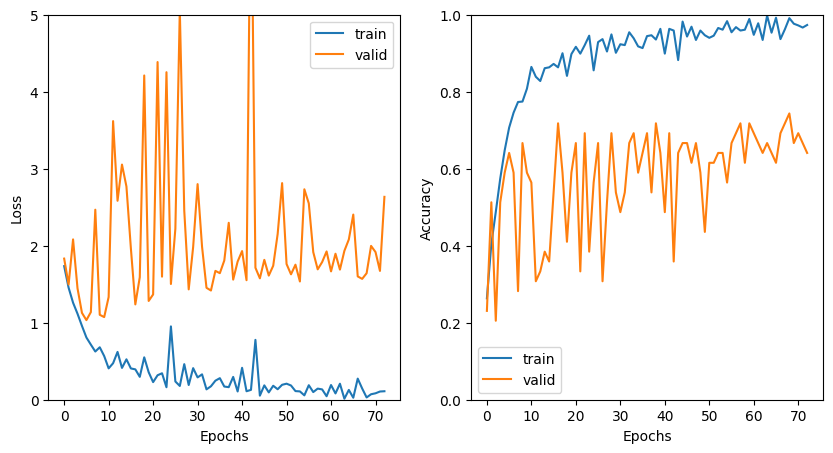

In [6]:
utils.plot_history(eV2L_top3_history, (0, 5), (0, 1))

In [7]:
eV2L_top1_best = keras.models.load_model('eV2L_top2.keras')
test_loss, test_acc = eV2L_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2025-01-19 18:03:17.495653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8397', 8 bytes spill stores, 8 bytes spill loads

2025-01-19 18:03:17.603602: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8397_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-19 18:03:17.623174: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8397', 252 bytes spill stores, 252 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.8000 - loss: 1.0672
Test accuracy: 0.80%, Test loss: 1.07


## Second Trial: MobileNetV2 + Top1

In [ ]:
def mV2_top1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = basemodels.MV2()(inputs, training=False)
    x = topmodels.top1(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

    return model

mV2_top1_history = mV2_top1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('mV2_top1.keras'),
        utils.callback_earlystop(80)
    ],
)

In [ ]:
utils.plot_history(mV2_top1_history)

In [ ]:
mV2_top1_best = keras.models.load_model('mV2_top1.keras')
test_loss, test_acc = mV2_top1_best.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")